# Part 2.2 - Train Final XGBoost model
Use the final training and testing data sets, containing statistical features and embedded timeseries features, to train an XGBoost classifier.

In [15]:
import cudf as gd
import pandas as pd
import numpy as np
import math
import xgboost as xgb
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt

In [16]:
train_final_gd = gd.from_pandas(pd.read_pickle("train_gdf.pkl"))
test_final_gd = gd.from_pandas(pd.read_pickle("test_gdf.pkl"))

In [17]:
test_final_gd.head().to_pandas()

,object_id,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,mean_passband,mean_detected,sum_flux_ratio_sq,...,bottleneck6,bottleneck7,bottleneck8,bottleneck9,bottleneck10,bottleneck11,bottleneck12,bottleneck13,bottleneck14,bottleneck15
0,2432745,0,NaN,0.7562,0.0301,43.352196,0.005,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2432779,0,0.5079,0.5467,0.0336,42.494404,0.093,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2432785,0,NaN,0.3393,0.0401,41.265503,0.067,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2432798,0,NaN,0.3930,0.9962,41.639095,0.008,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2432832,0,NaN,0.7017,0.0137,43.153496,0.029,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

y = train_final_gd['target'].to_array()

classes = sorted(np.unique(y))

# Build classes with labels from [0, n-1]
lbl = LabelEncoder()
y = lbl.fit_transform(y)

Set our class weights and build a multi-weighted cross-entropy loss function to train our XGBoost model

In [19]:
def multi_weighted_logloss(y_true, y_preds, classes, class_weights):
    """
    Computes the weighted cross-entropy 
    refactor from
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true) # one-hot encodes y_true values
    
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)

    # Transform to log
    y_p_log = np.log(y_p)
    
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)

    # Weight average and divide by the number of positives
    class_arr = np.array([class_weights[k] for k in sorted(class_weights.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    
    return loss

def xgb_multi_weighted_logloss(y_predicted, y_true, classes, class_weights):
    loss = multi_weighted_logloss(y_true.get_label(), y_predicted, 
                                  classes, class_weights)
    return 'wloss', loss

In [20]:
from functools import partial

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weights = {c: 1 for c in classes}
class_weights.update({c:2 for c in [64, 15]})

func_loss = partial(xgb_multi_weighted_logloss, 
                        classes=classes, 
                        class_weights=class_weights)

Preprocess our columns to fill `nan` values with zeros

In [21]:
cols = [i for i in test_final_gd.columns if i not in ['object_id','target']]
for col in cols:
    train_final_gd[col] = train_final_gd[col].fillna(0).astype('float32')

for col in cols:
    test_final_gd[col] = test_final_gd[col].fillna(0).astype('float32')

Perform a stratified split of our training dataset into 90% training and 10% validation datasets. 

In [22]:
X = train_final_gd[cols].as_matrix()
Xt = test_final_gd[cols].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,stratify=y)

Set the parameters for XGBoost to build our ensemble of trees   

In [23]:
gpu_params = {
            'objective': 'multi:softprob', 
            'tree_method': 'hist', 
            'nthread': 16, 
            'num_class':14,
            'max_depth': 7, 
            'silent':0,
            'subsample':0.7,
            'colsample_bytree': 0.7,
            "objective": "multi:softprob",
            "tree_method": "gpu_hist"
}

Build DMatrix objects with our train, validation, and test datasets 

In [29]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dvalid = xgb.DMatrix(data=X_test, label=y_test)
dtest = xgb.DMatrix(data=Xt)

Train our XGBoost model

In [30]:
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

clf = xgb.train(gpu_params, 
                dtrain=dtrain,
                num_boost_round=60,
                evals=watchlist,
                feval=func_loss,
                early_stopping_rounds=10,
                verbose_eval=1000)

yp = clf.predict(dvalid)

gpu_loss = multi_weighted_logloss(y_test, yp, classes, class_weights)

ysub = clf.predict(dtest)

line = 'validation loss %.4f'%gpu_loss
print(colored(line,'green'))

[0]	eval-merror:0.247134	train-merror:0.190571	eval-wloss:1.76342	train-wloss:1.62092
Multiple eval metrics have been passed: 'train-wloss' will be used for early stopping.

Will train until train-wloss hasn't improved in 10 rounds.
[59]	eval-merror:0.174522	train-merror:0	eval-wloss:0.838652	train-wloss:0.028231
validation loss 0.8387


In [31]:
y_hat = clf.predict(dvalid)

In [32]:
y_pred = np.argmax(y_hat, axis=1)

Normalized confusion matrix
[[0.86666667 0.         0.06666667 0.         0.         0.
  0.         0.         0.06666667 0.         0.         0.
  0.         0.        ]
 [0.         0.84       0.         0.06       0.         0.
  0.04       0.         0.         0.         0.         0.06
  0.         0.        ]
 [0.01075269 0.         0.97849462 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.01075269 0.        ]
 [0.         0.00840336 0.         0.70588235 0.         0.
  0.11764706 0.00840336 0.         0.00840336 0.         0.1512605
  0.         0.        ]
 [0.         0.         0.         0.22222222 0.11111111 0.
  0.         0.         0.         0.         0.         0.66666667
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.66666667
  0.         0.         0.         0.         0.         0.
  0.33333333 0.        ]
 [0.         0.         0.         0.4375     0.         0.
  0.35416667 0.  

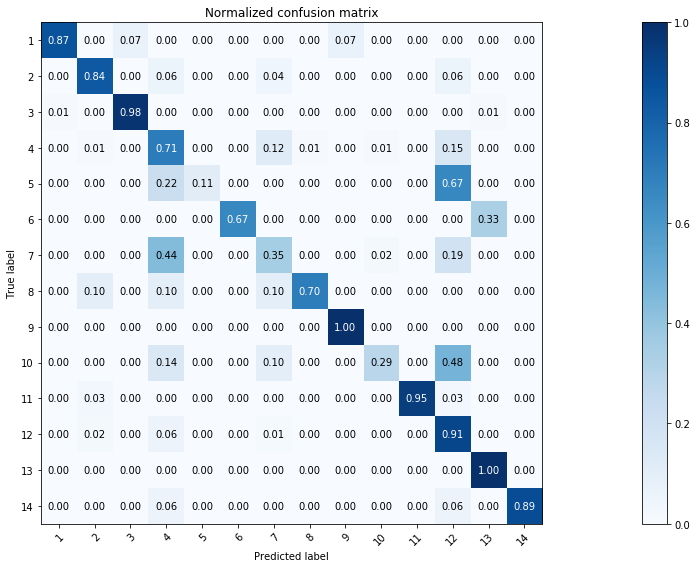

In [33]:
from utils import plot_confusion_matrix
plot_confusion_matrix(y_test, y_pred, np.arange(1, len(classes)+1), normalize=True)

## Independent Exercise

Now that you have trained an XGBoost model using both the timeseries embeddings and the statistical features,
1. re-run the previous notebook, but don't merge the timseries features into your training and test datasets before storing them. 
2. Use your new dataset to train a new XGBoost classifier. 
3. Compare the accuracy and confusion matrix against the model that included the timeseries embedding features. 